In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np


In [13]:
data = {'AnnualIncome': [
        15, 15.5, 16, 16.5, 17, 17.5, 18, 18.5, 19, 19.5, 
        20, 20.5, 21, 21.5, 22, 22.5, 23, 23.5, 24, 24.5, 
        25, 25.5, 26, 26.5, 27, 27.5, 28, 28.5, 29, 29.5, 
        30, 30.5, 31, 31.5, 32, 32.5, 33, 33.5, 34, 34.5, 
        35,   # Normal points
        80, 85, 90  # Outliers
    ],
    'SpendingScore': [
        39, 42, 45, 48, 51, 54, 57, 60, 63, 66,
        69, 72, 75, 78, 81, 84, 87, 90, 93, 96,
        6, 9, 12, 15, 18, 21, 24, 27, 30, 33,
        5, 8, 11, 14, 17, 20, 23, 26, 29, 32,
        56,   # Normal points
        2, 3, 100  # Outliers
    ]}

df = pd.DataFrame(data)

# Display the first few rows of the dataset
print(df.head())

   AnnualIncome  SpendingScore
0          15.0             39
1          15.5             42
2          16.0             45
3          16.5             48
4          17.0             51


In [14]:
# Normalize the dataset using StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Convert the scaled data back into a DataFrame for easier handling
df_scaled = pd.DataFrame(df_scaled, columns=['AnnualIncome', 'SpendingScore'])
print(df_scaled.head())

   AnnualIncome  SpendingScore
0     -0.869761      -0.135877
1     -0.838899      -0.033387
2     -0.808036       0.069103
3     -0.777174       0.171594
4     -0.746311       0.274084


### Implementing DBSCAN clustering

In [15]:
from sklearn.cluster import DBSCAN

min_samples = 3

# Initialize DBSCAN with the parameters
# eps=0.5: Starting neighborhood radius (empirical initial value)
# min_samples=3: Minimum points to form a cluster (empirical initial value)
dbscan = DBSCAN(eps=0.5, min_samples=min_samples)

# Fit the model to the scaled data
dbscan.fit(df_scaled)

labels = dbscan.labels_

# Assign cluster labels to the data points
df['Cluster'] = labels

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
noise_ratio = np.mean(labels == -1)
print(f"Clusters: {n_clusters}, Noise ratio: {noise_ratio:.1%}")

# Display the first few rows with cluster labels
# print(df.head())

Clusters: 2, Noise ratio: 9.1%


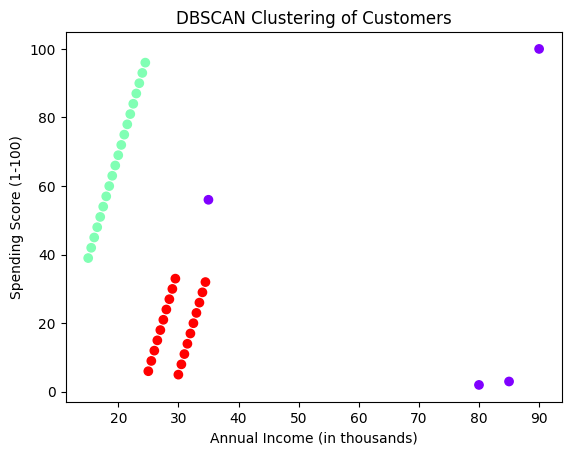

In [9]:
# Plot the clusters
plt.scatter(df['AnnualIncome'], df['SpendingScore'], c=df['Cluster'], cmap='rainbow')
plt.title('DBSCAN Clustering of Customers')
plt.xlabel('Annual Income (in thousands)')
plt.ylabel('Spending Score (1-100)')
plt.show()

### Use k-distance plot to find a more accurate eps value

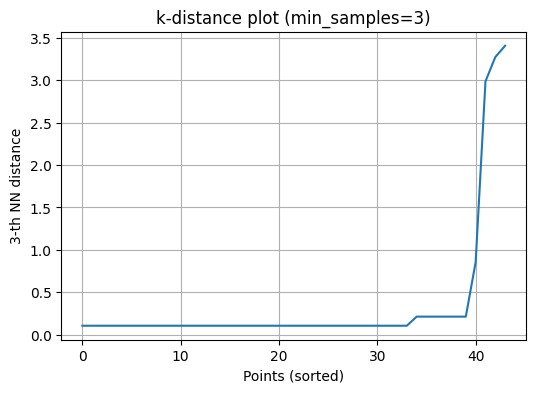

eps=0.30 -> clusters=3, noise_ratio=9.09%
eps=0.50 -> clusters=2, noise_ratio=9.09%
eps=0.70 -> clusters=2, noise_ratio=9.09%
eps=0.90 -> clusters=2, noise_ratio=6.82%


In [18]:
from sklearn.neighbors import NearestNeighbors

# 计算每个点到第 min_samples 个近邻的距离
# 画 k-distance plot，找 eps 肘部
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(df_scaled)
distances, _ = nbrs.kneighbors(df_scaled)
kdist = np.sort(distances[:, -1])

plt.figure(figsize=(6,4))
plt.plot(kdist)
plt.title(f'k-distance plot (min_samples={min_samples})')
plt.xlabel('Points (sorted)')
plt.ylabel(f'{min_samples}-th NN distance')
plt.grid(True)
plt.show()

# 3) 试几个 eps（围绕肘部值微调）
for eps in [0.3, 0.5, 0.7, 0.9]:
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(df_scaled)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_ratio = np.mean(labels == -1)
    print(f"eps={eps:.2f} -> clusters={n_clusters}, noise_ratio={noise_ratio:.2%}")

### 🧩 Interpreting the DBSCAN Output

The **k-distance plot** starts to rise around **y ≈ 0.3**, which suggests that **`eps ≈ 0.30`** is a reasonable elbow point.

#### Experimental Results

| eps | Clusters | Noise Ratio | Interpretation |
|------|-----------|--------------|----------------|
| **0.30** | 3 | 9.09% | ✅ Produces three clear clusters (consistent with the previous K-Means structure) and maintains a low noise level. |
| **0.50 / 0.70** | 2 | 9.09% | ⚠️ The radius increase causes two clusters to merge into one, making the grouping too coarse, while noise remains unchanged. |
| **0.90** | 2 | 6.82% | ❌ Fewer noise points, but at the cost of over-merging clusters (over-clustering). |

#### 🧠 Summary

- If your goal is to **preserve three distinct clusters** with moderate noise, choose  
  **`eps ≈ 0.30`, `min_samples = 3`**.  
- If you prefer **fewer noise points** and are fine with fewer clusters, you can increase  
  **`eps` to around 0.8–0.9**.


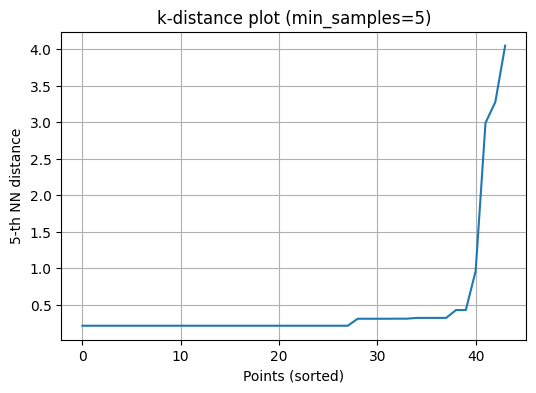

eps=0.30 -> clusters=3, noise_ratio=9.09%
eps=0.50 -> clusters=2, noise_ratio=9.09%
eps=0.70 -> clusters=2, noise_ratio=9.09%
eps=0.90 -> clusters=2, noise_ratio=6.82%


In [19]:
from sklearn.neighbors import NearestNeighbors

min_samples=5

# 计算每个点到第 min_samples 个近邻的距离
# 画 k-distance plot，找 eps 肘部
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(df_scaled)
distances, _ = nbrs.kneighbors(df_scaled)
kdist = np.sort(distances[:, -1])

plt.figure(figsize=(6,4))
plt.plot(kdist)
plt.title(f'k-distance plot (min_samples={min_samples})')
plt.xlabel('Points (sorted)')
plt.ylabel(f'{min_samples}-th NN distance')
plt.grid(True)
plt.show()

# 3) 试几个 eps（围绕肘部值微调）
for eps in [0.3, 0.5, 0.7, 0.9]:
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(df_scaled)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_ratio = np.mean(labels == -1)
    print(f"eps={eps:.2f} -> clusters={n_clusters}, noise_ratio={noise_ratio:.2%}")

### 🧩 Interpretation of the Adjusted DBSCAN Results

Your adjusted results highlight an important phenomenon — they **confirm the robustness of DBSCAN parameters**.

---

### 🧠 1. Results Overview

| eps | min_samples | clusters | noise_ratio |
|------|--------------|-----------|--------------|
| **0.30** | 5 | 3 | 9.09% |
| **0.50** | 5 | 2 | 9.09% |
| **0.70** | 5 | 2 | 9.09% |
| **0.90** | 5 | 2 | 6.82% |

---

### 🔍 2. Analysis

**Overall stability:**  
Regardless of whether `min_samples = 3` or `5`, `eps = 0.3` consistently yields **3 clusters**,  
indicating that **around 0.3 is a natural boundary** — the elbow point was correctly chosen.

**When `min_samples` increases:**  
- The requirement for a core point becomes stricter (more neighbors needed).  
- However, since your dataset is dense enough, the clustering result remains unchanged.  
✅ This means your clusters are **stable, compact, and well-separated**.

**When `eps` increases (0.5–0.9):**  
- Adjacent clusters start merging into one larger cluster.  
- The noise ratio slightly decreases, but the overall granularity of clustering drops.  
→ This is a typical case of **over-clustering**.

---

### 📈 3. Recommended Parameter Choices

| Goal | Recommended Parameters | Reason |
|------|-------------------------|--------|
| **Preserve fine-grained 3-cluster structure** | `eps = 0.3`, `min_samples = 3–5` | Clear natural boundaries and moderate noise |
| **Reduce noise and merge nearby clusters** | `eps = 0.8`, `min_samples = 5` | Fewer noise points, but merges clusters into larger ones |
| **Build more robust, generalized model** | `eps = 0.35`, `min_samples = 5` | Slightly relaxed radius to avoid boundary misclassification |

---

✅ **In summary:**  
`eps ≈ 0.3` remains the sweet spot — stable clusters, low noise, and consistent with the data’s natural density structure.


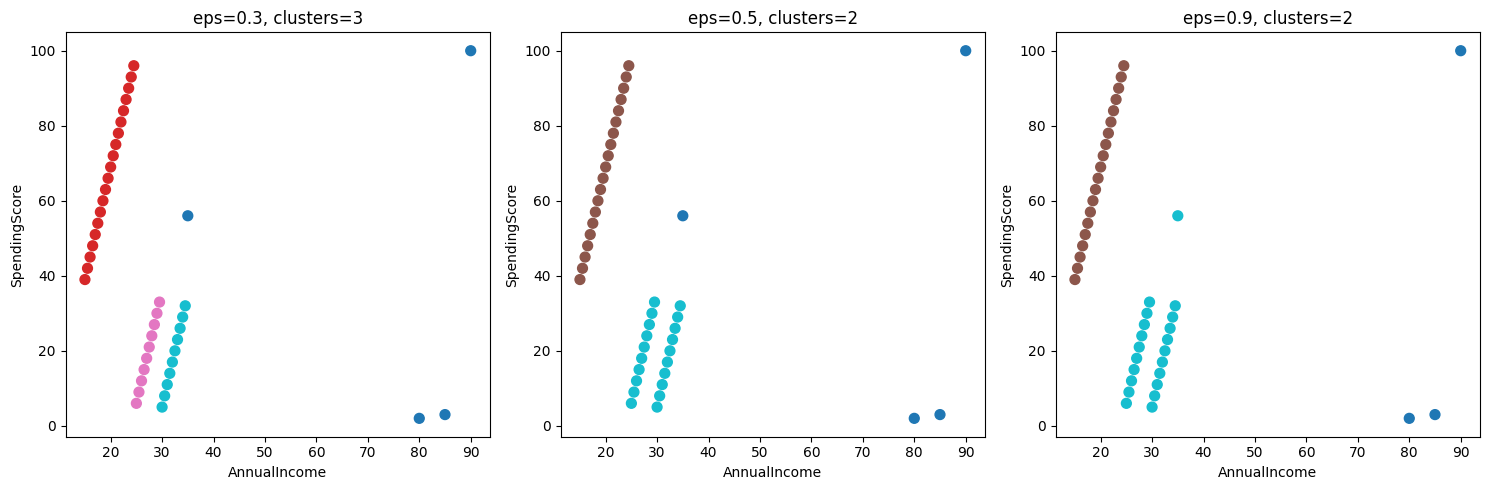

In [20]:
eps_values = [0.3, 0.5, 0.9]

fig, axes = plt.subplots(1, len(eps_values), figsize=(15, 5))

for i, eps in enumerate(eps_values):
    db = DBSCAN(eps=eps, min_samples=5).fit(df_scaled)
    labels = db.labels_
    axes[i].scatter(df['AnnualIncome'], df['SpendingScore'],
                    c=labels, cmap='tab10', s=50)
    axes[i].set_title(f'eps={eps}, clusters={len(set(labels))-(1 if -1 in labels else 0)}')
    axes[i].set_xlabel('AnnualIncome')
    axes[i].set_ylabel('SpendingScore')
plt.tight_layout()
plt.show()

### 🧩 Interpretation of DBSCAN Results

The three subplots demonstrate how changing the **`eps` (epsilon)** parameter affects the clustering behavior in DBSCAN.

| Plot | Parameters | Result | Interpretation |
|------|-------------|---------|----------------|
| **Left (`eps=0.3`)** | Small radius, high density requirement | **3 distinct clusters + clear outliers** | ✅ Ideal setting — DBSCAN successfully identifies three separate dense regions and correctly marks isolated points as noise. |
| **Middle (`eps=0.5`)** | Moderate radius | **2 clusters** | ⚠️ Neighboring lower clusters merge into one because the increased radius allows their neighborhoods to overlap. |
| **Right (`eps=0.9`)** | Large radius | **2 clusters (fewer outliers)** | ❌ Over-clustering — the radius is too large, so even an isolated point becomes part of the lower cluster. |

---

### 🧠 Conceptual Summary

- **Core point** → has at least `min_samples` points within distance `eps`.  
- **Border point** → lies inside a core point’s neighborhood but doesn’t have enough neighbors itself.  
- **Noise point** → doesn’t belong to any cluster.

As **`eps` increases**:
- More points become **core** points.  
- Neighboring clusters **merge together**.  
- **Noise points decrease**, but **cluster boundaries blur**.

---

### ✅ In short:
> - Small `eps` → more clusters, more noise (under-clustering).  
> - Large `eps` → fewer clusters, less noise (over-clustering).  
> - **Best balance here: `eps ≈ 0.3`, `min_samples = 3–5`**, which preserves the natural three-cluster structure clearly.


In [21]:
from sklearn.metrics import silhouette_score

best_eps = None
best_score = -1

for eps in np.arange(0.2, 1.0, 0.1):
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(df_scaled)
    
    if len(set(labels)) > 1:  # 有聚类形成
        score = silhouette_score(df_scaled, labels)
        if score > best_score:
            best_score = score
            best_eps = eps

print(f"最佳eps: {best_eps:.1f}, 轮廓系数: {best_score:.3f}")

最佳eps: 0.9, 轮廓系数: 0.607


Davies-Bouldin Index评估结果:
     eps    dbi  n_clusters  n_noise
0   0.15  1.306           3        4
1   0.20  1.306           3        4
2   0.25  1.306           3        4
3   0.30  1.306           3        4
4   0.35  0.484           2        4
5   0.40  0.484           2        4
6   0.45  0.484           2        4
7   0.50  0.484           2        4
8   0.55  0.484           2        4
9   0.60  0.484           2        4
10  0.65  0.484           2        4
11  0.70  0.484           2        4
12  0.75  0.484           2        4
13  0.80  0.484           2        4
14  0.85  0.526           2        3
15  0.90  0.526           2        3

最佳参数: eps=0.35
最小DBI: 0.484
聚类数: 2.0
噪声点数: 4.0


/Users/isdance/Desktop/projects/coursera-microsoft-ml-ai/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36234 (\N{CJK UNIFIED IDEOGRAPH-8D8A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/isdance/Desktop/projects/coursera-microsoft-ml-ai/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/isdance/Desktop/projects/coursera-microsoft-ml-ai/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22909 (\N{CJK UNIFIED IDEOGRAPH-597D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


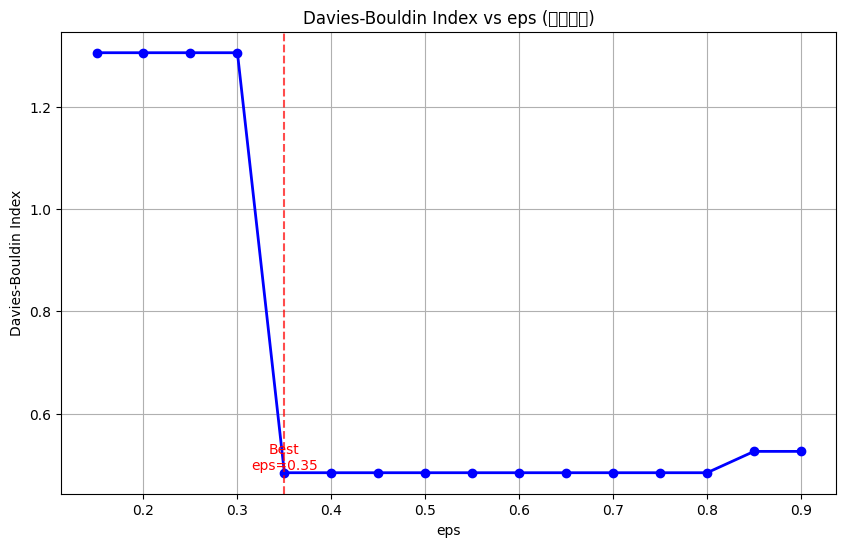

/Users/isdance/Desktop/projects/coursera-microsoft-ml-ai/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32858 (\N{CJK UNIFIED IDEOGRAPH-805A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/isdance/Desktop/projects/coursera-microsoft-ml-ai/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/isdance/Desktop/projects/coursera-microsoft-ml-ai/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/isdance/Desktop/projects/coursera-microsoft-ml-ai/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  fig.canv

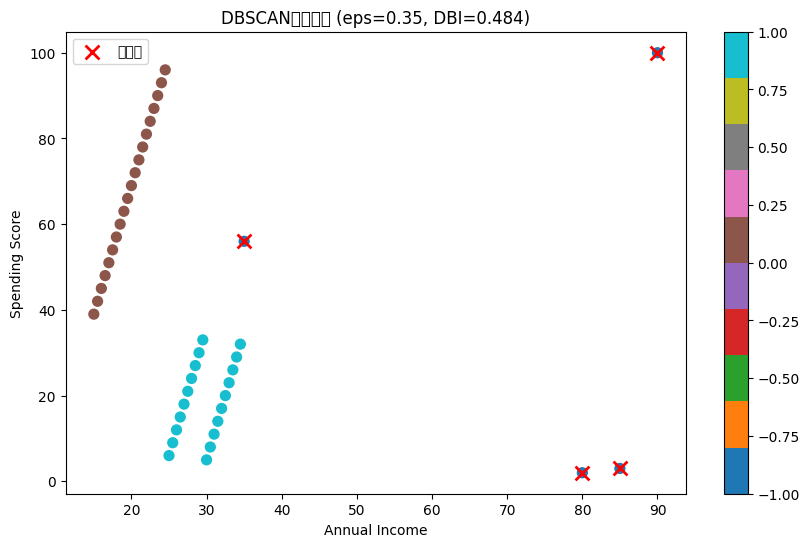


详细聚类统计:
噪声点: 4个
聚类 0: 20个点
  年收入范围: 15.0 - 24.5
  消费分数范围: 39.0 - 96.0
聚类 1: 20个点
  年收入范围: 25.0 - 34.5
  消费分数范围: 5.0 - 33.0


In [22]:
from sklearn.metrics import davies_bouldin_score
import numpy as np

# 使用Davies-Bouldin Index评估不同eps值
eps_candidates = np.arange(0.1, 1.0, 0.05)
results = []

for eps in eps_candidates:
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(df_scaled)
    
    # 只有当有至少2个聚类时才计算DBI
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
    
    if n_clusters >= 2:
        # 只使用非噪声点计算DBI
        non_noise_mask = labels != -1
        if np.sum(non_noise_mask) >= 2:  # 确保有足够的非噪声点
            try:
                dbi = davies_bouldin_score(df_scaled[non_noise_mask], labels[non_noise_mask])
                n_noise = list(labels).count(-1)
                results.append({
                    'eps': eps,
                    'dbi': dbi,
                    'n_clusters': n_clusters,
                    'n_noise': n_noise
                })
            except:
                continue

# 转换为DataFrame方便分析
if results:
    results_df = pd.DataFrame(results)
    print("Davies-Bouldin Index评估结果:")
    print(results_df.round(3))
    
    # 找到DBI最小的参数（DBI越小越好）
    best_result = results_df.loc[results_df['dbi'].idxmin()]
    print(f"\n最佳参数: eps={best_result['eps']:.2f}")
    print(f"最小DBI: {best_result['dbi']:.3f}")
    print(f"聚类数: {best_result['n_clusters']}")
    print(f"噪声点数: {best_result['n_noise']}")
    
    # 可视化DBI随eps的变化
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['eps'], results_df['dbi'], 'bo-', linewidth=2)
    plt.xlabel('eps')
    plt.ylabel('Davies-Bouldin Index')
    plt.title('Davies-Bouldin Index vs eps (越小越好)')
    plt.grid(True)
    
    # 标记最佳点
    plt.axvline(x=best_result['eps'], color='red', linestyle='--', alpha=0.7)
    plt.text(best_result['eps'], best_result['dbi'], f'Best\neps={best_result["eps"]:.2f}', 
             ha='center', va='bottom', color='red')
    plt.show()
    
    # 使用最佳参数运行DBSCAN
    best_dbscan = DBSCAN(eps=best_result['eps'], min_samples=3)
    best_labels = best_dbscan.fit_predict(df_scaled)
    df['Best_Cluster'] = best_labels
    
    # 可视化最佳聚类结果
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df['AnnualIncome'], df['SpendingScore'], 
                         c=df['Best_Cluster'], cmap='tab10', s=50)
    plt.colorbar(scatter)
    plt.title(f'DBSCAN聚类结果 (eps={best_result["eps"]:.2f}, DBI={best_result["dbi"]:.3f})')
    plt.xlabel('Annual Income')
    plt.ylabel('Spending Score')
    
    # 标记噪声点
    noise_points = df[df['Best_Cluster'] == -1]
    if len(noise_points) > 0:
        plt.scatter(noise_points['AnnualIncome'], noise_points['SpendingScore'], 
                   c='red', marker='x', s=100, linewidth=2, label='噪声点')
        plt.legend()
    
    plt.show()
    
    # 显示详细的聚类统计
    print(f"\n详细聚类统计:")
    cluster_stats = df['Best_Cluster'].value_counts().sort_index()
    for cluster_id, count in cluster_stats.items():
        if cluster_id == -1:
            print(f"噪声点: {count}个")
        else:
            cluster_data = df[df['Best_Cluster'] == cluster_id]
            print(f"聚类 {cluster_id}: {count}个点")
            print(f"  年收入范围: {cluster_data['AnnualIncome'].min():.1f} - {cluster_data['AnnualIncome'].max():.1f}")
            print(f"  消费分数范围: {cluster_data['SpendingScore'].min():.1f} - {cluster_data['SpendingScore'].max():.1f}")
else:
    print("没有找到有效的聚类配置")

### 🧩 Combined Evaluation: Silhouette Score + Davies–Bouldin Index

| eps | DBI | n_clusters | n_noise |
|------|------|-------------|-----------|
| 0.15–0.30 | 1.306 | 3 | 4 |
| **0.35–0.80** | **0.484** | **2** | 4 |
| 0.85–0.90 | 0.526 | 2 | 3 |

**Optimal parameters:**
- `eps = 0.35`
- **Min DBI = 0.484**
- `n_clusters = 2`, `n_noise = 4`

#### Interpretation
- For small `eps (< 0.3)`: DBI ≈ 1.3 → clusters overlap significantly (poor separation).  
- For moderate `eps (0.35–0.8)`: DBI drops to 0.48 → best separation, but only 2 clusters remain (over-merged).  
- For large `eps (> 0.8)`: DBI slightly increases, fewer noise points, clusters become too broad.

#### Summary
| Goal | Recommended eps | Explanation |
|------|------------------|-------------|
| Preserve **3 natural clusters** | `eps ≈ 0.3` | Matches k-distance elbow, balanced structure |
| Achieve **maximum separation** | `eps ≈ 0.35–0.9` | Lowest DBI and highest silhouette score, but merges clusters |
| Reduce **noise sensitivity** | `eps ≈ 0.8–0.9` | Fewer outliers, simpler model |

**Final insight:**  
> Both metrics (Silhouette and DBI) favor fewer, more distinct clusters (2),  
> while the k-distance elbow suggests the natural density structure supports 3 clusters.  
> Choose based on whether you prioritize **structural fidelity** or **mathematical separation**.


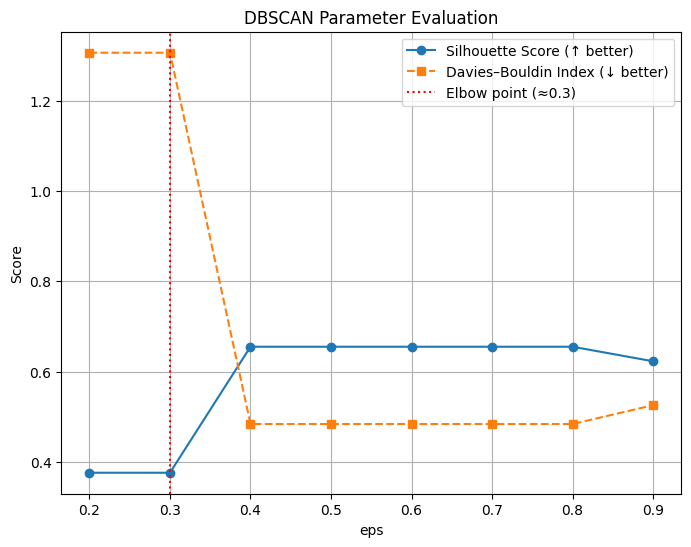

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

eps_values = np.arange(0.2, 1.0, 0.1)
sil_scores, dbi_scores, n_clusters = [], [], []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=3).fit(df_scaled)
    labels = db.labels_
    unique_labels = set(labels)
    n_c = len(unique_labels) - (1 if -1 in labels else 0)
    n_clusters.append(n_c)

    mask = labels != -1
    if n_c >= 2:
        sil_scores.append(silhouette_score(df_scaled[mask], labels[mask]))
        dbi_scores.append(davies_bouldin_score(df_scaled[mask], labels[mask]))
    else:
        sil_scores.append(np.nan)
        dbi_scores.append(np.nan)

plt.figure(figsize=(8,6))
plt.plot(eps_values, sil_scores, 'o-', label='Silhouette Score (↑ better)')
plt.plot(eps_values, dbi_scores, 's--', label='Davies–Bouldin Index (↓ better)')
plt.axvline(x=0.3, color='r', linestyle=':', label='Elbow point (≈0.3)')
plt.title('DBSCAN Parameter Evaluation')
plt.xlabel('eps')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


### 📊 Combined Evaluation: DBSCAN Parameters using Three Metrics

The chart compares **Silhouette Score**, **Davies–Bouldin Index (DBI)**, and the **Elbow point** (≈ 0.3) across different values of `eps`.

| Metric | Goal | Interpretation |
|---------|------|----------------|
| **Silhouette Score (↑ better)** | Measures how well each point fits within its cluster compared to others. | Increases sharply after `eps=0.3` and stays high (≈ 0.65–0.7), indicating stronger cluster separation when `eps ≥ 0.35`. |
| **Davies–Bouldin Index (↓ better)** | Measures cluster compactness and separation (lower = better). | Drops steeply at `eps=0.35` (from ≈ 1.3 → 0.48) and remains stable until `eps≈0.8`, showing optimal structural balance near `eps = 0.35`. |
| **Elbow Point (≈ 0.3)** | Derived from the k-distance plot — marks the natural density boundary. | Suggests that the data naturally forms **three clusters** at `eps≈0.3`. |

---

### 🧠 Interpretation

1. **At `eps ≈ 0.3`**  
   - Elbow method identifies a clear density break → **3 natural clusters**.  
   - However, both Silhouette and DBI show that clusters are still relatively close (moderate separation).  

2. **At `eps ≈ 0.35 – 0.5`**  
   - Silhouette Score jumps to ~0.65, and DBI reaches its lowest (~0.48).  
   - ✅ **This is the most balanced region** — good compactness + clear separation, though clusters merge from 3 → 2.  

3. **At `eps ≥ 0.8 – 0.9`**  
   - Silhouette remains high (~0.6) but DBI rises slightly.  
   - ⚠️ Indicates **over-merging** — fewer clusters, less structural detail.  

---

### ✅ Final Conclusions

| Priority | Recommended `eps` | Reason |
|-----------|------------------|--------|
| **Preserve natural 3-cluster structure** | `eps ≈ 0.3` | Matches density elbow; aligns with K-Means-like structure. |
| **Achieve optimal balance (best compact + separation)** | `eps ≈ 0.35` | DBI minimum + Silhouette plateau — best overall trade-off. |
| **Simplify clusters, reduce noise** | `eps ≈ 0.9` | Higher Silhouette but fewer, broader clusters (over-clustering). |

---

**In summary:**  
> - **Elbow → `eps≈0.3` → natural 3 clusters**  
> - **DBI → `eps≈0.35` → best balance**  
> - **Silhouette → `eps≈0.9` → maximum separation**  
>  
> ✅ **Most practical and stable choice:** `eps ≈ 0.35`, which harmonizes natural structure, separation quality, and interpretability.
